In [1]:
%matplotlib inline
import os, sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext import data
from torchtext import vocab

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
df.shape

(2225, 2)

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Categories')]

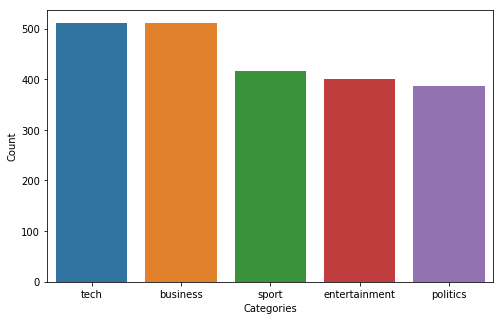

In [4]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.category.unique(),y=df.category.value_counts())
ax.set(xlabel='Categories', ylabel = 'Count')

In [5]:
df['text'] = df.text.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|████████████████████████████████████████████████████████████████| 2225/2225 [00:00<00:00, 202081.51it/s]


In [39]:
le = LabelEncoder()
le.fit(df.category)
df.category = le.transform(df.category)

LabelEncoder()

In [44]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

,category,text
0,4,tv future in the hands of viewers with home th...
1,0,worldcom boss left books alone former worldc...
2,3,tigers wary of farrell gamble leicester say ...
3,3,yeading face newcastle in fa cup premiership s...
4,1,ocean s twelve raids box office ocean s twelve...
5,2,howard hits back at mongrel jibe michael howar...
6,2,blair prepares to name poll date tony blair is...
7,3,henman hopes ended in dubai third seed tim hen...
8,3,wilkinson fit to face edinburgh england captai...
9,1,last star wars not for children the sixth an...


In [45]:
traindf, validdf = split_train_test(df, test_size=0.2)

In [46]:
print(traindf.shape)
print(traindf.category.value_counts())
traindf.head()

(1780, 2)
3    413
0    409
2    334
4    319
1    305
Name: category, dtype: int64


,category,text
0,1,farrell due to make us tv debut actor colin fa...
1,0,china continues rapid growth china s economy h...
2,0,ebbers aware of worldcom fraud former worldc...
3,1,school tribute for tv host carson more than 1 ...
4,4,broadband fuels online expression fast web acc...


In [47]:
print(validdf.shape)
print(validdf.category.value_counts())
validdf.head()

(445, 2)
0    101
3     98
2     83
4     82
1     81
Name: category, dtype: int64


,category,text
0,2,brown and blair face new rift claims for the u...
1,0,small firms hit by rising costs rising fuel ...
2,1,spirit awards hail sideways the comedy sideway...
3,4,microsoft releases patches microsoft has warne...
4,3,arsenal through on penalties arsenal win 4-2 o...


In [48]:
traindf.to_csv('traindf.csv', index = False)
validdf.to_csv('validdf.csv', index = False)

In [49]:
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): return [w.text.lower() for w in nlp(clean(s))]
def clean(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) 
    text = re.sub(r'https?:/\/\S+', ' ', text) #
    return text.strip()

In [50]:
text_field = data.Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
label_field = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

train_val_fields = [
    ('category', label_field),
    ('text', text_field)
]

In [51]:
trainds, validds = data.TabularDataset.splits(path='', format='csv', train='traindf.csv', validation='validdf.csv', fields=train_val_fields, skip_header=True)

In [52]:
type(trainds)

torchtext.data.dataset.TabularDataset

In [53]:
print(trainds.fields.items())
trainds[0].category

dict_items([('category', <torchtext.data.field.Field object at 0x000001E772BC3048>), ('text', <torchtext.data.field.Field object at 0x000001E772BC3B00>)])


'1'

In [28]:
vec = vocab.Vectors('GloVe/glove.6B.100d.txt')

100%|██████████████████████████████████████████████████████████████████████▉| 399602/400000 [00:49<00:00, 13676.69it/s]

In [ ]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, 1)


    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [54]:
text_field.build_vocab(trainds, validds, vectors=vec)
label_field.build_vocab(trainds)

In [55]:
text_field.vocab.vectors.shape

torch.Size([29160, 100])

In [56]:
text_field.vocab.vectors[text_field.vocab.stoi['the']]

tensor([-0.0382, -0.2449,  0.7281, -0.3996,  0.0832,  0.0440, -0.3914,  0.3344,
        -0.5755,  0.0875,  0.2879, -0.0673,  0.3091, -0.2638, -0.1323, -0.2076,
         0.3340, -0.3385, -0.3174, -0.4834,  0.1464, -0.3730,  0.3458,  0.0520,
         0.4495, -0.4697,  0.0263, -0.5415, -0.1552, -0.1411, -0.0397,  0.2828,
         0.1439,  0.2346, -0.3102,  0.0862,  0.2040,  0.5262,  0.1716, -0.0824,
        -0.7179, -0.4153,  0.2033, -0.1276,  0.4137,  0.5519,  0.5791, -0.3348,
        -0.3656, -0.5486, -0.0629,  0.2658,  0.3020,  0.9977, -0.8048, -3.0243,
         0.0125, -0.3694,  2.2167,  0.7220, -0.2498,  0.9214,  0.0345,  0.4674,
         1.1079, -0.1936, -0.0746,  0.2335, -0.0521, -0.2204,  0.0572, -0.1581,
        -0.3080, -0.4162,  0.3797,  0.1501, -0.5321, -0.2055, -1.2526,  0.0716,
         0.7056,  0.4974, -0.4206,  0.2615, -1.5380, -0.3022, -0.0734, -0.2831,
         0.3710, -0.2522,  0.0162, -0.0171, -0.3898,  0.8742, -0.7257, -0.5106,
        -0.5203, -0.1459,  0.8278,  0.27

In [96]:
traindl, validdl = data.BucketIterator.splits(datasets=(trainds, validds), 
                                            batch_sizes=(3,3), 
                                            sort_key=lambda x: len(x.text), 
                                            device=None, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [58]:
len(traindl)

594

In [59]:
batch = next(iter(traindl))
type(batch)

torchtext.data.batch.Batch

In [60]:
batch.category

tensor([4, 2, 2])

In [61]:
batch.text

(tensor([[1461,   41,   79],
         [1191,    3,  549],
         [2347,   86,    3],
         ...,
         [ 335,   40,  663],
         [ 114, 4345,   16],
         [ 579,  977,   14]]), tensor([506, 506, 506]))

In [62]:
batch.dataset.fields

{'category': <torchtext.data.field.Field at 0x1e772bc3048>,
 'text': <torchtext.data.field.Field at 0x1e772bc3b00>}

In [64]:
batch.__dict__

{'batch_size': 3,
 'dataset': <torchtext.data.dataset.TabularDataset at 0x1e762a1f668>,
 'fields': dict_keys(['category', 'text']),
 'input_fields': ['category', 'text'],
 'target_fields': [],
 'category': tensor([4, 2, 2]),
 'text': (tensor([[1461,   41,   79],
          [1191,    3,  549],
          [2347,   86,    3],
          ...,
          [ 335,   40,  663],
          [ 114, 4345,   16],
          [ 579,  977,   14]]), tensor([506, 506, 506]))}

In [65]:
val_batch = next(iter(validdl))
val_batch.__dict__

{'batch_size': 3,
 'dataset': <torchtext.data.dataset.TabularDataset at 0x1e772bd1550>,
 'fields': dict_keys(['category', 'text']),
 'input_fields': ['category', 'text'],
 'target_fields': [],
 'category': tensor([3, 3, 3]),
 'text': (tensor([[ 8600,  7778, 10893],
          [ 1635,    88,   916],
          [  842,    88,   461],
          [    5, 13234, 16618],
          [ 1856,  7778, 27401],
          [ 4969,   148,   565],
          [  492,   122,   467],
          [15626,    88,   509],
          [ 8600,    13,   821],
          [   20,  2287,  1599],
          [   39,  5452,    30],
          [ 3620,   271,    90],
          [  108,     2,    89],
          [  101,   468,    52],
          [    5,    13,   424],
          [ 2092,  4650,    18],
          [   29,   514,  1428],
          [  340,    19, 15845],
          [  204,   371,  3432],
          [ 5086, 13884,  2185],
          [    9,     8,  2454],
          [  196,  2258,     7],
          [  547,   295,     2],
        

In [66]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [67]:
train_batch_it = BatchGenerator(traindl, 'text', 'category')
next(iter(train_batch_it))

((tensor([[ 820,  364, 2672],
          [8251,  848, 1807],
          [1452, 9104, 2788],
          ...,
          [ 596,   34,    1],
          [  13, 1200,    1],
          [ 669,    1,    1]]), tensor([338, 337, 335])), tensor([0, 2, 4]))

In [80]:
vocab_size = len(text_field.vocab)
embedding_dim = 100
n_hidden = 64
n_out = 5

In [81]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out,self.bidirectional = vocab_size, embedding_dim, n_hidden, n_out, bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
#         return F.log_softmax(outp, dim=-1)
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden))
        else:
            return torch.zeros((1,batch_size,self.n_hidden))

In [102]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    losses_train = []
    losses_val = []
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for (X,lengths),y in t:
            t.set_description(f'Epoch {epoch}')
            lengths = lengths.cpu().numpy()
            
            opt.zero_grad()
            pred = model(X, lengths)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            pred_idx = torch.max(pred, dim=1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        losses_train.append(train_loss)
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X,lengths),y in tqdm_notebook(val_dl, leave=False):
                pred = model(X, lengths.cpu().numpy())
                loss = loss_fn(pred, y)
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/len(val_dl)
            losses_val.append(valloss)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valloss:.4f} val_acc: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}')
    plt.plot(losses_train,label = 'train_loss')
    plt.plot(losses_val, label = 'valid_loss')
    plt.legend()
    plt.savefig('plot1.jpg')
    

In [83]:
traindl, validdl = data.BucketIterator.splits(datasets=(trainds, validds), batch_sizes=(512,1024), sort_key=lambda x: len(x.text),  sort_within_batch=True, repeat=False)
train_batch_it = BatchGenerator(traindl, 'text', 'category')
val_batch_it = BatchGenerator(validdl, 'text', 'category')

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: train_loss: 1.5976 train_acc: 0.2455 | val_loss: 1.5434 val_acc: 0.3618


Epoch 1: train_loss: 1.5213 train_acc: 0.4174 | val_loss: 1.4785 val_acc: 0.5169


Epoch 2: train_loss: 1.4526 train_acc: 0.5562 | val_loss: 1.4141 val_acc: 0.5888


Epoch 3: train_loss: 1.3875 train_acc: 0.6360 | val_loss: 1.3481 val_acc: 0.6562


Epoch 4: train_loss: 1.3200 train_acc: 0.6899 | val_loss: 1.2797 val_acc: 0.6809


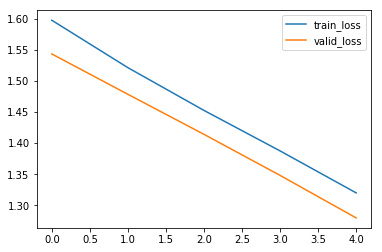

In [103]:
m = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['text'].vocab.vectors)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)
fit(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=5)

In [87]:
class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        if bidirectional:
            self.out = nn.Linear(self.n_hidden*2*2, self.n_out)
        else:
            self.out = nn.Linear(self.n_hidden*2, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1)
        self.h = self.init_hidden(bs)
        seq = seq.transpose(0,1)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)        
        outp = self.out(torch.cat([avg_pool,max_pool],dim=1))
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden))
        else:
            return torch.zeros((1,batch_size,self.n_hidden))

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: train_loss: 1.6373 train_acc: 0.1899 | val_loss: 1.5917 val_acc: 0.3258


Epoch 1: train_loss: 1.5660 train_acc: 0.3567 | val_loss: 1.5540 val_acc: 0.4112


Epoch 2: train_loss: 1.5119 train_acc: 0.4837 | val_loss: 1.5225 val_acc: 0.5461


Epoch 3: train_loss: 1.4692 train_acc: 0.4938 | val_loss: 1.4890 val_acc: 0.6180


Epoch 4: train_loss: 1.4166 train_acc: 0.5309 | val_loss: 1.4563 val_acc: 0.6247


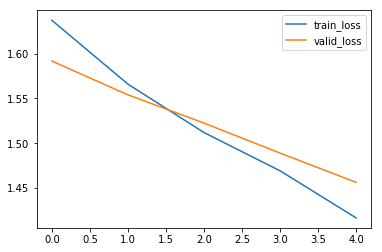

In [104]:
m = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['text'].vocab.vectors)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)
fit(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=5)